# Domain-Adversarial Training of Neural Networks (DANN)



In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler,Dataset,DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import shutil
import os
from torch.utils import data

## Tool Functions

In [2]:
def adjust_learning_rate(optimizer,epoch):
    lr=0.001*0.1**(epoch//10)
    for param_group in optimizer.param_groups:
        param_group['lr']=lr
    return lr

def accuracy(output,target,topk=(1,)):
    maxk=max(topk)
    batch_size=target.size(0)
    _,pred=output.topk(maxk,1,True,True)
    pred=pred.t()
    correct=pred.eq(target.view(1,-1).expand_as(pred))
    res=[]
    for k in topk:
        correct_k=correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100/batch_size))
    return res

def matplotlib_imshow(img,one_channel=False):
    if one_channel:
        img=img.mean(dim=0)
    np_img=img.numpy()
    np_img=(np_img-np.min(np_img))/(np.max(np_img)-np.min(np_img))
    if one_channel:
        plt.imshow(np_img,cmap="Greys")
    else:
        plt.imshow(np.transpose(np_img,(1,2,0)))

class ColoredMNIST(Dataset):
    def __init__(self, file_name):
        self.data_label = torch.load(file_name)
        # self.data_label=transforms.ToTensor()(self.data_label)

    def __getitem__(self, index):
        img, target = self.data_label[index]
        img = transforms.ToTensor()(img)
        return img, target

    def __len__(self):
        return len(self.data_label)

    def __add__(self,other):
        pass

class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.val=0
        self.avg=0
        self.sum=0
        self.count=0
    def update(self,val,n=1):
        self.val=val
        self.sum+=val*n
        self.count+=n
        self.avg=self.sum/self.count

## Tensorboard

In [3]:
log_dir="minist_experiment_1"
remove_log_dir=True
if remove_log_dir and os.path.exists(log_dir):
    shutil.rmtree(log_dir)

## Loading Data

In [4]:
image_size=28
batch_size=32

transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5],std=[0.5])])
train_ds = ColoredMNIST('./dataset/MNIST_source/train1_source.pt') # source domain training datasets
train_dl = data.DataLoader(dataset=train_ds,batch_size=batch_size,shuffle=True)
test_ds = ColoredMNIST('./dataset/MNIST_source/test_source.pt') # source domain testing datasets
test_dl = data.DataLoader(dataset=test_ds,batch_size=batch_size,shuffle=False)
train_m_ds = ColoredMNIST('./dataset/ColoredMNIST/train1.pt') # target domain training datasets
train_m_dl = data.DataLoader(dataset=train_m_ds,batch_size=batch_size,shuffle=True)
test_m_ds = ColoredMNIST('./dataset/ColoredMNIST/test.pt') # target domain testing datasets
test_m_dl = data.DataLoader(dataset=test_m_ds,batch_size=batch_size,shuffle=False)


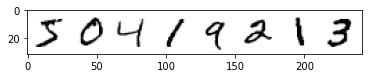

In [5]:
%matplotlib inline

writer=SummaryWriter(log_dir)
show_images=[train_ds[i][0] for i in range(8)]
show_labels=[train_ds[i][1] for i in range(8)]
show_img_grid=make_grid(show_images)
matplotlib_imshow(show_img_grid,one_channel=True)
writer.add_image("mnist_images",show_img_grid)

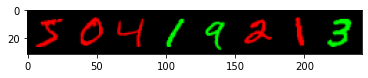

In [6]:
show_images=[train_m_ds[i][0] for i in range(8)]
show_labels=[train_m_ds[i][1] for i in range(8)]
show_img_grid=make_grid(show_images)
matplotlib_imshow(show_img_grid,one_channel=False)
writer.add_image("mnist_m_images",show_img_grid)

## Source-Only Training

在源域上独立训练CNN模型

In [7]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,48,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,num_classes)
        )
    def forward(self,x):
        x=x.expand(x.data.shape[0],3,image_size,image_size)
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        x=self.classifier(x)
        return x

用一个5层的神经网络在mnist上使用Adam训练，准确率约为73%(考虑到理想的最高正确率为75%，这里CNN的表现已经足够)

In [8]:
cnn_model=CNN()
optimizer=Adam(cnn_model.parameters(),lr=0.001)
Loss=nn.CrossEntropyLoss()
epochs=5
train_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()
print_freq=100
# cnn_model.cuda()
for epoch in range(epochs):
    lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for images,labels in tqdm(train_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        optimizer.zero_grad()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        train_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        train_cnt.update(images.size(0),1)
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}]".format(epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                                                            train_top1.val,train_top1.avg))
    for images,labels in tqdm(test_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        test_top1.update(top1,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:0[100/625],Loss:[0.717,0.793],prec[46.8750,50.3750]
Epoch:0[200/625],Loss:[0.601,0.735],prec[65.6250,54.2969]
Epoch:0[300/625],Loss:[0.624,0.705],prec[68.7500,57.8021]
Epoch:0[400/625],Loss:[0.551,0.681],prec[75.0000,60.8203]
Epoch:0[500/625],Loss:[0.585,0.667],prec[78.1250,62.7750]
Epoch:0[600/625],Loss:[0.583,0.658],prec[75.0000,63.9948]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:0,val,Loss:[0.601],prec[71.2350]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:1[100/625],Loss:[0.616,0.603],prec[71.8750,71.2188]
Epoch:1[200/625],Loss:[0.510,0.598],prec[81.2500,71.5000]
Epoch:1[300/625],Loss:[0.689,0.597],prec[59.3750,71.6771]
Epoch:1[400/625],Loss:[0.494,0.594],prec[78.1250,72.0469]
Epoch:1[500/625],Loss:[0.788,0.592],prec[46.8750,72.2562]
Epoch:1[600/625],Loss:[0.605,0.592],prec[65.6250,72.3333]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:1,val,Loss:[0.602],prec[71.8050]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:2[100/625],Loss:[0.587,0.590],prec[68.7500,72.3438]
Epoch:2[200/625],Loss:[0.513,0.585],prec[81.2500,72.8750]
Epoch:2[300/625],Loss:[0.651,0.583],prec[65.6250,73.0104]
Epoch:2[400/625],Loss:[0.478,0.581],prec[81.2500,73.1406]
Epoch:2[500/625],Loss:[0.535,0.583],prec[81.2500,72.9750]
Epoch:2[600/625],Loss:[0.655,0.582],prec[65.6250,73.0365]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:2,val,Loss:[0.584],prec[72.8750]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:3[100/625],Loss:[0.339,0.586],prec[96.8750,72.1250]
Epoch:3[200/625],Loss:[0.479,0.581],prec[87.5000,72.8750]
Epoch:3[300/625],Loss:[0.599,0.576],prec[71.8750,73.4583]
Epoch:3[400/625],Loss:[0.621,0.578],prec[68.7500,73.3984]
Epoch:3[500/625],Loss:[0.618,0.579],prec[71.8750,73.3000]
Epoch:3[600/625],Loss:[0.616,0.577],prec[71.8750,73.5365]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:3,val,Loss:[0.581],prec[73.1950]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:4[100/625],Loss:[0.503,0.585],prec[81.2500,72.6562]
Epoch:4[200/625],Loss:[0.573,0.577],prec[71.8750,73.4688]
Epoch:4[300/625],Loss:[0.751,0.575],prec[59.3750,73.6562]
Epoch:4[400/625],Loss:[0.642,0.573],prec[65.6250,73.7812]
Epoch:4[500/625],Loss:[0.562,0.572],prec[75.0000,73.8438]
Epoch:4[600/625],Loss:[0.590,0.574],prec[78.1250,73.7188]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:4,val,Loss:[0.589],prec[72.8700]


## Direct Transferring

直接用mnist数据集训练的网络识别ColoredMNIST数据集，准确率约为72.3%.可以看作领域适应方法准确率的上界。

In [9]:
test_m_top1=AverageMeter()
test_m_loss=AverageMeter()
for images,labels in tqdm(test_m_dl):
    # images=images.cuda()
    # labels=labels.cuda()
    predict=cnn_model(images)
    losses=Loss(predict,labels)
    test_m_loss.update(losses.data,images.size(0))
    top1=accuracy(predict.data,labels,topk=(1,))[0]
    test_m_top1.update(top1,images.size(0))
print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_m_loss.avg,test_m_top1.avg))

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:4,val,Loss:[0.643],prec[72.3050]


## Direct Training

直接使用ColoredMNIST训练，准确率约为30.3050%，可以看坐领域适应方法准确率的下界。

In [10]:
train_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()
print_freq=200
# cnn_model.cuda()
epochs=5
for epoch in range(epochs):
    lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for images,labels in tqdm(train_m_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        optimizer.zero_grad()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        train_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        train_cnt.update(images.size(0),1)
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}]".format(epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                                                                   train_top1.val,train_top1.avg))
    for images,labels in tqdm(test_m_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        predict=cnn_model(images)
        losses=Loss(predict,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predict.data,labels,topk=(1,))[0]
        test_top1.update(top1,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg))
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)

  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:0[200/625],Loss:[0.384,0.449],prec[81.2500,78.9219]
Epoch:0[400/625],Loss:[0.479,0.444],prec[78.1250,78.7891]
Epoch:0[600/625],Loss:[0.544,0.445],prec[75.0000,78.8958]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:0,val,Loss:[1.114],prec[24.1550]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:1[200/625],Loss:[0.435,0.413],prec[87.5000,80.7656]
Epoch:1[400/625],Loss:[0.484,0.421],prec[78.1250,80.0859]
Epoch:1[600/625],Loss:[0.550,0.426],prec[75.0000,79.9323]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:1,val,Loss:[1.169],prec[21.8350]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:2[200/625],Loss:[0.516,0.420],prec[62.5000,80.0625]
Epoch:2[400/625],Loss:[0.426,0.417],prec[84.3750,80.4297]
Epoch:2[600/625],Loss:[0.362,0.419],prec[78.1250,80.0000]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:2,val,Loss:[1.133],prec[29.4550]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:3[200/625],Loss:[0.377,0.407],prec[78.1250,81.0938]
Epoch:3[400/625],Loss:[0.509,0.413],prec[71.8750,80.2500]
Epoch:3[600/625],Loss:[0.525,0.413],prec[81.2500,80.3177]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:3,val,Loss:[1.103],prec[28.5550]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:4[200/625],Loss:[0.361,0.411],prec[78.1250,80.7031]
Epoch:4[400/625],Loss:[0.363,0.410],prec[84.3750,80.7109]
Epoch:4[600/625],Loss:[0.389,0.409],prec[84.3750,80.8594]


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:4,val,Loss:[1.174],prec[25.2050]


## Gradient Reverse Layer (GRL)

梯度反转层，这一层正向表现为恒等变换，反向传播是改变梯度的符号，alpha用来平衡域损失的权重。

In [11]:
from torch.autograd import Function

class GRL(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

## DANN

In [12]:
class DANN(nn.Module):
    def __init__(self,num_classes=10):
        super(DANN,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,32,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32,48,5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.avgpool=nn.AdaptiveAvgPool2d((5,5))
        self.task_classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,num_classes)
        )
        self.domain_classifier=nn.Sequential(
            nn.Linear(48*5*5,100),
            nn.ReLU(inplace=True),
            nn.Linear(100,2)
        )
        self.GRL=GRL()
    def forward(self,x,alpha):
        x = x.expand(x.data.shape[0], 3, image_size,image_size)
        x=self.features(x)
        x=self.avgpool(x)
        x=torch.flatten(x,1)
        task_predict=self.task_classifier(x)
        x=GRL.apply(x,alpha)
        domain_predict=self.domain_classifier(x)
        return task_predict,domain_predict

## Domain Transfer Training

使用DANN进行领域迁移训练，使用mnist上的有标签数据和ColoredMNIST上的无标签数据，准确率约为50.41%.

In [13]:
train_loss=AverageMeter()
train_domain_loss=AverageMeter()
train_task_loss=AverageMeter()
test_loss=AverageMeter()
test_top1=AverageMeter()
test_domain_acc=AverageMeter()
train_top1=AverageMeter()
train_cnt=AverageMeter()

print_freq=200
domain_model=DANN()
# domain_model.cuda()
domain_loss=nn.CrossEntropyLoss()
task_loss=nn.CrossEntropyLoss()
lr=0.001
optimizer=Adam(domain_model.parameters(),lr=lr)
epochs=100
states=[]

for epoch in range(epochs):

    #lr=adjust_learning_rate(optimizer,epoch)
    writer.add_scalar("lr",lr,epoch)
    train_loss.reset()
    train_domain_loss.reset()
    train_task_loss.reset()
    train_top1.reset()
    train_cnt.reset()
    test_top1.reset()
    test_loss.reset()
    for source,target in zip(train_dl,train_m_dl):
        train_cnt.update(images.size(0),1)
        p = float(train_cnt.count + epoch * len(train_dl)) / (epochs *len(train_dl))
        alpha = torch.tensor(2. / (1. + np.exp(-10 * p)) - 1)
        src_imgs=source[0]
        src_labels=source[1]
        dst_imgs=target[0]
        optimizer.zero_grad()
        
        src_predict,src_domains=domain_model(src_imgs,alpha)
        src_label_loss=task_loss(src_predict,src_labels)
        src_domain_loss=domain_loss(src_domains,torch.ones(len(src_domains)).long())
        
        _,dst_domains=domain_model(dst_imgs,alpha)
        dst_domain_loss=domain_loss(dst_domains,torch.zeros(len(dst_domains)).long())
        
        losses=src_label_loss+src_domain_loss+dst_domain_loss
        
        train_loss.update(losses.data,images.size(0))
        train_domain_loss.update(dst_domain_loss.data,images.size(0))
        train_task_loss.update(src_label_loss.data,images.size(0))
        top1=accuracy(src_predict.data,src_labels,topk=(1,))[0]
        train_top1.update(top1,images.size(0))
        
        losses.backward()
        optimizer.step()
        if train_cnt.count%print_freq==0:
            print("Epoch:{}[{}/{}],Loss:[{:.3f},{:.3f}],domain loss:[{:.3f},{:.3f}],label loss:[{:.3f},{:.3f}],prec[{:.4f},{:.4f}],alpha:{}".format(
                epoch,train_cnt.count,len(train_dl),train_loss.val,train_loss.avg,
                train_domain_loss.val,train_domain_loss.avg,
                train_task_loss.val,train_task_loss.avg,train_top1.val,train_top1.avg,alpha))
    for images,labels in tqdm(test_m_dl):
        # images=images.cuda()
        # labels=labels.cuda()
        predicts,domains=domain_model(images,0)
        losses=task_loss(predicts,labels)
        test_loss.update(losses.data,images.size(0))
        top1=accuracy(predicts.data,labels,topk=(1,))[0]
        domain_acc=accuracy(domains.data,torch.zeros(len(domains)).long(),topk=(1,))[0]
        test_top1.update(top1,images.size(0))
        test_domain_acc.update(domain_acc,images.size(0))
    print("Epoch:{},val,Loss:[{:.3f}],prec[{:.4f}],domain_acc[{:.4f}]".format(epoch,test_loss.avg,test_top1.avg,test_domain_acc.avg))
    states.append([test_loss.avg.item(), test_top1.avg.item(),test_domain_acc.avg.item()])
    writer.add_scalar("train_loss",train_loss.avg,epoch)
    writer.add_scalar("test_loss",test_loss.avg,epoch)    
    writer.add_scalar("train_top1",train_top1.avg,epoch)
    writer.add_scalar("test_top1",test_top1.avg,epoch)
    writer.add_scalar("test_domain",test_domain_acc.avg,epoch)

Epoch:0[200/625],Loss:[1.742,1.889],domain loss:[0.139,0.786],label loss:[0.516,0.699],prec[81.2500,61.1719],alpha:0.015998634806462242
Epoch:0[400/625],Loss:[3.192,2.600],domain loss:[0.845,1.267],label loss:[0.707,0.668],prec[53.1250,63.6172],alpha:0.03198908180540405
Epoch:0[600/625],Loss:[0.679,3.192],domain loss:[0.001,1.828],label loss:[0.678,0.678],prec[62.5000,61.5677],alpha:0.04796316994220873


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:0,val,Loss:[0.504],prec[88.7650],domain_acc[100.0000]
Epoch:1[200/625],Loss:[0.773,0.627],domain loss:[0.076,0.001],label loss:[0.658,0.624],prec[68.7500,67.5312],alpha:0.0659043346837902
Epoch:1[400/625],Loss:[0.500,0.930],domain loss:[0.000,0.227],label loss:[0.500,0.621],prec[87.5000,67.9766],alpha:0.08181670364476323
Epoch:1[600/625],Loss:[0.656,2.206],domain loss:[0.000,1.238],label loss:[0.656,0.637],prec[59.3750,65.0521],alpha:0.09768746989410348


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:1,val,Loss:[0.679],prec[49.5900],domain_acc[100.0000]
Epoch:2[200/625],Loss:[0.672,0.684],domain loss:[0.000,0.000],label loss:[0.672,0.684],prec[62.5000,55.7500],alpha:0.11548248661898008
Epoch:2[400/625],Loss:[0.670,0.677],domain loss:[0.000,0.000],label loss:[0.670,0.677],prec[59.3750,57.7656],alpha:0.13123864986596323
Epoch:2[600/625],Loss:[0.765,1.846],domain loss:[0.061,0.843],label loss:[0.704,0.669],prec[40.6250,60.0052],alpha:0.14692878722649882


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:2,val,Loss:[1.280],prec[40.7200],domain_acc[100.0000]
Epoch:3[200/625],Loss:[0.721,0.704],domain loss:[0.000,0.002],label loss:[0.721,0.700],prec[37.5000,51.0000],alpha:0.16449185585604442
Epoch:3[400/625],Loss:[0.668,0.700],domain loss:[0.000,0.001],label loss:[0.668,0.698],prec[62.5000,49.8984],alpha:0.1800167504577601
Epoch:3[600/625],Loss:[0.689,0.700],domain loss:[0.000,0.001],label loss:[0.689,0.699],prec[53.1250,50.1250],alpha:0.19545247777947417


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:3,val,Loss:[0.768],prec[10.0650],domain_acc[100.0000]
Epoch:4[200/625],Loss:[0.703,0.690],domain loss:[0.000,0.000],label loss:[0.703,0.690],prec[65.6250,52.9062],alpha:0.21270229740018176
Epoch:4[400/625],Loss:[0.646,0.686],domain loss:[0.000,0.000],label loss:[0.646,0.686],prec[59.3750,54.2656],alpha:0.22792531458279308
Epoch:4[600/625],Loss:[0.655,0.678],domain loss:[0.000,0.000],label loss:[0.655,0.678],prec[65.6250,56.5938],alpha:0.243037713855222


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:4,val,Loss:[2.913],prec[10.0200],domain_acc[100.0000]
Epoch:5[200/625],Loss:[0.556,0.640],domain loss:[0.000,0.000],label loss:[0.556,0.640],prec[75.0000,65.1562],alpha:0.2598989185823417
Epoch:5[400/625],Loss:[0.585,0.638],domain loss:[0.000,0.000],label loss:[0.585,0.638],prec[71.8750,65.5000],alpha:0.27475511396339947
Epoch:5[600/625],Loss:[35.010,1.281],domain loss:[34.389,0.580],label loss:[0.621,0.633],prec[71.8750,66.4219],alpha:0.2894812739857362


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:5,val,Loss:[1.244],prec[10.8600],domain_acc[100.0000]
Epoch:6[200/625],Loss:[0.696,0.698],domain loss:[0.000,0.000],label loss:[0.696,0.698],prec[40.6250,49.5625],alpha:0.3058856354111792
Epoch:6[400/625],Loss:[0.695,0.696],domain loss:[0.000,0.000],label loss:[0.695,0.696],prec[46.8750,50.2891],alpha:0.3203167194475147
Epoch:6[600/625],Loss:[0.692,0.695],domain loss:[0.000,0.000],label loss:[0.692,0.695],prec[62.5000,49.9375],alpha:0.3346006496541831


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:6,val,Loss:[0.680],prec[76.0150],domain_acc[100.0000]
Epoch:7[200/625],Loss:[0.689,0.693],domain loss:[0.000,0.000],label loss:[0.689,0.693],prec[56.2500,50.9219],alpha:0.3504880105676904
Epoch:7[400/625],Loss:[0.694,0.694],domain loss:[0.000,0.000],label loss:[0.694,0.694],prec[43.7500,50.1406],alpha:0.364443092801352
Epoch:7[600/625],Loss:[0.698,0.694],domain loss:[0.000,0.000],label loss:[0.698,0.694],prec[43.7500,50.3333],alpha:0.37823638558303885


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:7,val,Loss:[0.683],prec[77.3450],domain_acc[100.0000]
Epoch:8[200/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,51.0312],alpha:0.3935553063167454
Epoch:8[400/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.693,0.694],prec[46.8750,50.0859],alpha:0.4069913819036224
Epoch:8[600/625],Loss:[0.701,0.694],domain loss:[0.000,0.000],label loss:[0.701,0.694],prec[43.7500,50.4323],alpha:0.42025361660945926


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:8,val,Loss:[0.682],prec[64.0500],domain_acc[100.0000]
Epoch:9[200/625],Loss:[0.703,0.693],domain loss:[0.000,0.000],label loss:[0.703,0.693],prec[40.6250,50.6719],alpha:0.4349617318313266
Epoch:9[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,50.7344],alpha:0.44784391314578276
Epoch:9[600/625],Loss:[0.692,0.694],domain loss:[0.000,0.000],label loss:[0.692,0.694],prec[53.1250,50.3125],alpha:0.4605428088263632


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:9,val,Loss:[0.687],prec[66.2700],domain_acc[100.0000]
Epoch:10[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,51.0625],alpha:0.47460690756711865
Epoch:10[400/625],Loss:[0.708,0.693],domain loss:[0.000,0.000],label loss:[0.708,0.693],prec[40.6250,50.6172],alpha:0.48690841629268755
Epoch:10[600/625],Loss:[0.695,0.694],domain loss:[0.000,0.000],label loss:[0.695,0.694],prec[50.0000,50.3125],alpha:0.4990197521342994


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:10,val,Loss:[0.692],prec[69.2750],domain_acc[100.0000]
Epoch:11[200/625],Loss:[0.691,0.694],domain loss:[0.000,0.000],label loss:[0.691,0.694],prec[62.5000,50.0625],alpha:0.5124156062544918
Epoch:11[400/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.693,0.694],prec[68.7500,50.1953],alpha:0.5241175514991385
Epoch:11[600/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[53.1250,50.9948],alpha:0.53562488312072


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:11,val,Loss:[0.703],prec[58.9850],domain_acc[100.0000]
Epoch:12[200/625],Loss:[0.677,0.693],domain loss:[0.000,0.000],label loss:[0.677,0.693],prec[62.5000,50.8281],alpha:0.5483368586719488
Epoch:12[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.8125],alpha:0.5594278338412255
Epoch:12[600/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[50.0000,50.8385],alpha:0.5703220398447029


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:12,val,Loss:[0.700],prec[66.2700],domain_acc[100.0000]
Epoch:13[200/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[50.0000,50.9375],alpha:0.582342531610339
Epoch:13[400/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.693,0.694],prec[50.0000,50.7734],alpha:0.5928180669311505
Epoch:13[600/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.693,0.694],prec[50.0000,50.7188],alpha:0.6030967633123072


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:13,val,Loss:[0.706],prec[29.8800],domain_acc[100.0000]
Epoch:14[200/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,51.2812],alpha:0.614425495340025
Epoch:14[400/625],Loss:[0.691,0.694],domain loss:[0.000,0.000],label loss:[0.691,0.694],prec[56.2500,50.5391],alpha:0.6242874042434383
Epoch:14[600/625],Loss:[0.695,0.694],domain loss:[0.000,0.000],label loss:[0.695,0.694],prec[43.7500,50.8385],alpha:0.6339542647544443


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:14,val,Loss:[0.693],prec[48.6800],domain_acc[100.0000]
Epoch:15[200/625],Loss:[0.692,0.694],domain loss:[0.000,0.000],label loss:[0.692,0.694],prec[53.1250,50.4688],alpha:0.6445974993027463
Epoch:15[400/625],Loss:[0.694,0.694],domain loss:[0.000,0.000],label loss:[0.694,0.694],prec[46.8750,50.7109],alpha:0.65385315575444
Epoch:15[600/625],Loss:[0.691,0.694],domain loss:[0.000,0.000],label loss:[0.691,0.694],prec[53.1250,50.4844],alpha:0.6629171745196893


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:15,val,Loss:[0.717],prec[28.0100],domain_acc[100.0000]
Epoch:16[200/625],Loss:[0.699,0.694],domain loss:[0.000,0.000],label loss:[0.699,0.694],prec[40.6250,50.0312],alpha:0.6728868690993062
Epoch:16[400/625],Loss:[0.701,0.694],domain loss:[0.000,0.000],label loss:[0.701,0.694],prec[40.6250,50.2734],alpha:0.6815484499483511
Epoch:16[600/625],Loss:[0.702,0.694],domain loss:[0.000,0.000],label loss:[0.702,0.694],prec[40.6250,50.3594],alpha:0.6900231791331366


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:16,val,Loss:[0.723],prec[26.9600],domain_acc[100.0000]
Epoch:17[200/625],Loss:[0.695,0.694],domain loss:[0.000,0.000],label loss:[0.695,0.694],prec[43.7500,49.9062],alpha:0.6993361268805545
Epoch:17[400/625],Loss:[0.686,0.693],domain loss:[0.000,0.000],label loss:[0.686,0.693],prec[62.5000,50.3359],alpha:0.7074198489653143
Epoch:17[600/625],Loss:[0.686,0.694],domain loss:[0.000,0.000],label loss:[0.686,0.694],prec[71.8750,50.2969],alpha:0.7153226396659271


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:17,val,Loss:[0.823],prec[50.4100],domain_acc[100.0000]
Epoch:18[200/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.693,0.694],prec[50.0000,50.7344],alpha:0.723999622788764
Epoch:18[400/625],Loss:[0.689,0.694],domain loss:[0.000,0.000],label loss:[0.689,0.694],prec[56.2500,50.4922],alpha:0.7315249994555852
Epoch:18[600/625],Loss:[0.698,0.694],domain loss:[0.000,0.000],label loss:[0.698,0.694],prec[46.8750,50.3490],alpha:0.7388762687642882


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:18,val,Loss:[0.788],prec[53.3450],domain_acc[100.0000]
Epoch:19[200/625],Loss:[0.688,0.693],domain loss:[0.000,0.000],label loss:[0.688,0.693],prec[62.5000,50.4062],alpha:0.7469412488326295
Epoch:19[400/625],Loss:[0.700,0.693],domain loss:[0.000,0.000],label loss:[0.700,0.693],prec[43.7500,50.8281],alpha:0.7539303851814612
Epoch:19[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.3438],alpha:0.7607529270441293


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:19,val,Loss:[0.806],prec[52.8550],domain_acc[100.0000]
Epoch:20[200/625],Loss:[0.675,0.693],domain loss:[0.000,0.000],label loss:[0.675,0.693],prec[71.8750,50.4219],alpha:0.7682322899522251
Epoch:20[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[37.5000,50.5391],alpha:0.7747092309184456
Epoch:20[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,50.1615],alpha:0.7810275833073346


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:20,val,Loss:[0.829],prec[52.2750],domain_acc[100.0000]
Epoch:21[200/625],Loss:[0.690,0.694],domain loss:[0.000,0.000],label loss:[0.690,0.694],prec[62.5000,49.2812],alpha:0.7879494511608012
Epoch:21[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.2344],alpha:0.7939395917615266
Epoch:21[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.1979],alpha:0.7997794680836847


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:21,val,Loss:[0.854],prec[51.7100],domain_acc[100.0000]
Epoch:22[200/625],Loss:[0.704,0.693],domain loss:[0.000,0.000],label loss:[0.704,0.693],prec[37.5000,50.8750],alpha:0.8061730853233975
Epoch:22[400/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[46.8750,51.0391],alpha:0.8117026482228882
Epoch:22[600/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[37.5000,50.7656],alpha:0.8170904369288805


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:22,val,Loss:[0.838],prec[18.3400],domain_acc[100.0000]
Epoch:23[200/625],Loss:[0.701,0.693],domain loss:[0.000,0.000],label loss:[0.701,0.693],prec[40.6250,50.5156],alpha:0.8229856338211163
Epoch:23[400/625],Loss:[0.701,0.693],domain loss:[0.000,0.000],label loss:[0.701,0.693],prec[40.6250,50.8203],alpha:0.8280812158964155
Epoch:23[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[56.2500,50.4531],alpha:0.83304354901185


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:23,val,Loss:[0.888],prec[51.6700],domain_acc[100.0000]
Epoch:24[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,50.2031],alpha:0.8384702822631238
Epoch:24[400/625],Loss:[0.701,0.693],domain loss:[0.000,0.000],label loss:[0.701,0.693],prec[46.8750,50.2891],alpha:0.8431584690981058
Epoch:24[600/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,50.4323],alpha:0.8477218578730918


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:24,val,Loss:[0.904],prec[51.3950],domain_acc[100.0000]
Epoch:25[200/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[46.8750,50.4062],alpha:0.8527098255484877
Epoch:25[400/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[46.8750,50.2422],alpha:0.8570168707190711
Epoch:25[600/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[40.6250,50.1510],alpha:0.8612074047322389


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:25,val,Loss:[0.884],prec[17.2100],domain_acc[100.0000]
Epoch:26[200/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[59.3750,49.9062],alpha:0.8657857308026848
Epoch:26[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[40.6250,50.6797],alpha:0.8697372953702083
Epoch:26[600/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[40.6250,50.5885],alpha:0.8735804001585066


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:26,val,Loss:[0.913],prec[51.3450],domain_acc[100.0000]
Epoch:27[200/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[50.0000,50.2969],alpha:0.8777773827827478
Epoch:27[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.3828],alpha:0.8813983294988619
Epoch:27[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.3958],alpha:0.8849185770210712


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:27,val,Loss:[0.957],prec[50.4100],domain_acc[100.0000]
Epoch:28[200/625],Loss:[0.697,0.694],domain loss:[0.000,0.000],label loss:[0.697,0.694],prec[43.7500,50.6406],alpha:0.8887614939769035
Epoch:28[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,50.3594],alpha:0.8920757302271085
Epoch:28[600/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,50.4375],alpha:0.8952966961127684


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:28,val,Loss:[0.917],prec[51.6050],domain_acc[100.0000]
Epoch:29[200/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[40.6250,51.0625],alpha:0.8988116605231198
Epoch:29[400/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[68.7500,51.1484],alpha:0.90184202390397
Epoch:29[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[43.7500,50.4688],alpha:0.9047861853988957


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:29,val,Loss:[0.942],prec[51.0200],domain_acc[100.0000]
Epoch:30[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,50.6094],alpha:0.9079980449516107
Epoch:30[400/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[43.7500,50.8125],alpha:0.9107662255029345
Epoch:30[600/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[40.6250,50.7812],alpha:0.9134548942150438


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:30,val,Loss:[0.992],prec[50.6300],domain_acc[100.0000]
Epoch:31[200/625],Loss:[0.685,0.693],domain loss:[0.000,0.000],label loss:[0.685,0.693],prec[59.3750,52.0625],alpha:0.9163871673619761
Epoch:31[400/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[62.5000,51.3359],alpha:0.9189136607850381
Epoch:31[600/625],Loss:[0.698,0.744],domain loss:[0.000,0.035],label loss:[0.698,0.693],prec[37.5000,51.0260],alpha:0.9213669446885957


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:31,val,Loss:[0.693],prec[50.4100],domain_acc[99.5420]
Epoch:32[200/625],Loss:[0.690,22.075],domain loss:[0.000,18.519],label loss:[0.690,0.695],prec[59.3750,49.7969],alpha:0.9240417877543237
Epoch:32[400/625],Loss:[0.695,11.388],domain loss:[0.000,9.261],label loss:[0.695,0.694],prec[37.5000,50.3359],alpha:0.9263458743768787
Epoch:32[600/625],Loss:[0.690,7.825],domain loss:[0.000,6.175],label loss:[0.690,0.694],prec[62.5000,50.3750],alpha:0.9285826639905344


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:32,val,Loss:[0.693],prec[50.4100],domain_acc[99.5558]
Epoch:33[200/625],Loss:[0.698,0.696],domain loss:[0.000,0.001],label loss:[0.698,0.693],prec[46.8750,50.8594],alpha:0.9310208636620754
Epoch:33[400/625],Loss:[0.699,0.696],domain loss:[0.000,0.001],label loss:[0.699,0.693],prec[40.6250,50.7188],alpha:0.9331206084110155
Epoch:33[600/625],Loss:[0.710,0.696],domain loss:[0.000,0.001],label loss:[0.691,0.693],prec[59.3750,50.3854],alpha:0.9351585825782751


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:33,val,Loss:[0.693],prec[50.4100],domain_acc[99.5687]
Epoch:34[200/625],Loss:[0.693,0.696],domain loss:[0.000,0.001],label loss:[0.693,0.693],prec[50.0000,50.4688],alpha:0.9373795688361879
Epoch:34[400/625],Loss:[0.713,0.694],domain loss:[0.000,0.001],label loss:[0.713,0.693],prec[28.1250,51.2656],alpha:0.9392918380086868
Epoch:34[600/625],Loss:[0.691,0.694],domain loss:[0.000,0.001],label loss:[0.691,0.693],prec[59.3750,50.6094],alpha:0.9411474852428101


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:34,val,Loss:[0.693],prec[50.4100],domain_acc[99.5810]
Epoch:35[200/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,49.5938],alpha:0.943169360394529
Epoch:35[400/625],Loss:[0.693,0.694],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.1484],alpha:0.9449098515500804
Epoch:35[600/625],Loss:[0.691,0.694],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[53.1250,50.4479],alpha:0.9465985034325499


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:35,val,Loss:[0.694],prec[50.4100],domain_acc[99.5925]
Epoch:36[200/625],Loss:[0.688,0.692],domain loss:[0.000,0.000],label loss:[0.688,0.692],prec[56.2500,52.1250],alpha:0.9484380834943789
Epoch:36[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.9922],alpha:0.9500213653021949
Epoch:36[600/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,50.5781],alpha:0.951557238926604


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:36,val,Loss:[0.693],prec[50.4100],domain_acc[99.6035]
Epoch:37[200/625],Loss:[0.693,0.697],domain loss:[0.000,0.002],label loss:[0.693,0.693],prec[62.5000,50.9375],alpha:0.9532301041536
Epoch:37[400/625],Loss:[0.700,0.695],domain loss:[0.000,0.001],label loss:[0.700,0.693],prec[34.3750,50.5156],alpha:0.954669663508837
Epoch:37[600/625],Loss:[0.689,0.694],domain loss:[0.000,0.001],label loss:[0.689,0.693],prec[56.2500,50.8594],alpha:0.9560659104284508


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:37,val,Loss:[0.693],prec[50.4100],domain_acc[99.6140]
Epoch:38[200/625],Loss:[0.705,0.693],domain loss:[0.000,0.000],label loss:[0.705,0.693],prec[40.6250,48.9531],alpha:0.9575864623003194
Epoch:38[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[40.6250,49.9141],alpha:0.9588947564602104
Epoch:38[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.3333],alpha:0.9601635160208666


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:38,val,Loss:[0.693],prec[50.4100],domain_acc[99.6239]
Epoch:39[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,51.1406],alpha:0.9615450384509008
Epoch:39[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[43.7500,51.0312],alpha:0.9627335503341665
Epoch:39[600/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,50.9844],alpha:0.963886005651577


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:39,val,Loss:[0.693],prec[50.4100],domain_acc[99.6333]
Epoch:40[200/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,51.3281],alpha:0.9651407285924827
Epoch:40[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,51.1016],alpha:0.9662200237312486
Epoch:40[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.5938],alpha:0.9672664589029609


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:40,val,Loss:[0.693],prec[50.4100],domain_acc[99.6422]
Epoch:41[200/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[40.6250,50.0938],alpha:0.9684056228786844
Epoch:41[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,50.2344],alpha:0.9693854068127776
Epoch:41[600/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[37.5000,50.7188],alpha:0.9703352642417122


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:41,val,Loss:[0.693],prec[50.4100],domain_acc[99.6507]
Epoch:42[200/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[59.3750,50.2344],alpha:0.9713691846405414
Epoch:42[400/625],Loss:[31.839,1.528],domain loss:[31.147,0.691],label loss:[0.691,0.693],prec[56.2500,50.5312],alpha:0.9722583598020222
Epoch:42[600/625],Loss:[0.689,6.296],domain loss:[0.000,4.839],label loss:[0.689,0.693],prec[56.2500,50.6875],alpha:0.9731202967535377


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:42,val,Loss:[0.693],prec[50.4100],domain_acc[99.6588]
Epoch:43[200/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[43.7500,51.6875],alpha:0.9740584269783656
Epoch:43[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[37.5000,50.2656],alpha:0.9748651483328992
Epoch:43[600/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,50.3385],alpha:0.9756470920543165


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:43,val,Loss:[0.694],prec[50.4100],domain_acc[99.6666]
Epoch:44[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[46.8750,51.5781],alpha:0.9764980848453131
Epoch:44[400/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[62.5000,50.2188],alpha:0.9772298137403739
Epoch:44[600/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[65.6250,50.3125],alpha:0.9779390146448363


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:44,val,Loss:[0.694],prec[50.4100],domain_acc[99.6740]
Epoch:45[200/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[46.8750,51.4062],alpha:0.9787107810723079
Epoch:45[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[56.2500,50.9844],alpha:0.9793743368942611
Epoch:45[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.7917],alpha:0.980017419453663


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:45,val,Loss:[0.693],prec[50.4100],domain_acc[99.6811]
Epoch:46[200/625],Loss:[0.700,0.693],domain loss:[0.000,0.000],label loss:[0.700,0.693],prec[43.7500,51.9688],alpha:0.9807171852291141
Epoch:46[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,50.9297],alpha:0.9813187945958814
Epoch:46[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,50.8490],alpha:0.9819018057042852


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:46,val,Loss:[0.693],prec[50.4100],domain_acc[99.6879]
Epoch:47[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[34.3750,50.2969],alpha:0.9825361645799322
Epoch:47[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.0078],alpha:0.9830815078969468
Epoch:47[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.6250],alpha:0.9836099625601018


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:47,val,Loss:[0.693],prec[50.4100],domain_acc[99.6944]
Epoch:48[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.7031],alpha:0.9841849266853127
Epoch:48[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[43.7500,50.8672],alpha:0.9846791819732785
Epoch:48[600/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[43.7500,51.0000],alpha:0.9851581062548682


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:48,val,Loss:[0.693],prec[50.4100],domain_acc[99.7006]
Epoch:49[200/625],Loss:[0.685,0.693],domain loss:[0.000,0.000],label loss:[0.685,0.693],prec[75.0000,50.4688],alpha:0.9856791534358604
Epoch:49[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,51.0156],alpha:0.9861270374025659
Epoch:49[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[62.5000,50.4792],alpha:0.9865610086166827


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:49,val,Loss:[0.693],prec[50.4100],domain_acc[99.7066]
Epoch:50[200/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[40.6250,50.8438],alpha:0.9870331264865702
Epoch:50[400/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[53.1250,51.2812],alpha:0.9874389328644344
Epoch:50[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[56.2500,50.4375],alpha:0.987832117049158


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:50,val,Loss:[0.693],prec[50.4100],domain_acc[99.7124]
Epoch:51[200/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[59.3750,51.1562],alpha:0.9882598442019548
Epoch:51[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[56.2500,51.0859],alpha:0.9886274794105359
Epoch:51[600/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[40.6250,51.0365],alpha:0.9889836661517206


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:51,val,Loss:[0.693],prec[50.4100],domain_acc[99.7179]
Epoch:52[200/625],Loss:[0.689,0.693],domain loss:[0.000,0.000],label loss:[0.689,0.693],prec[56.2500,51.5938],alpha:0.9893711303286652
Epoch:52[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,51.1484],alpha:0.9897041465491687
Epoch:52[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.9740],alpha:0.990026781248601


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:52,val,Loss:[0.693],prec[50.4100],domain_acc[99.7232]
Epoch:53[200/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[43.7500,50.6250],alpha:0.9903777346903249
Epoch:53[400/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[59.3750,50.7188],alpha:0.9906793604589783
Epoch:53[600/625],Loss:[0.702,0.693],domain loss:[0.000,0.000],label loss:[0.702,0.693],prec[34.3750,50.9792],alpha:0.990971574158706


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:53,val,Loss:[0.693],prec[50.4100],domain_acc[99.7283]
Epoch:54[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,49.5469],alpha:0.9912894262541458
Epoch:54[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[50.0000,50.3906],alpha:0.99156259469473
Epoch:54[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,50.6562],alpha:0.991827231581002


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:54,val,Loss:[0.693],prec[50.4100],domain_acc[99.7333]
Epoch:55[200/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,51.2031],alpha:0.9921150789551008
Epoch:55[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[46.8750,50.6641],alpha:0.9923624537792108
Epoch:55[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[56.2500,50.8073],alpha:0.9926020964963598


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:55,val,Loss:[0.693],prec[50.4100],domain_acc[99.7380]
Epoch:56[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,50.8594],alpha:0.992862750684784
Epoch:56[400/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[40.6250,50.3281],alpha:0.9930867500926446
Epoch:56[600/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[43.7500,50.6875],alpha:0.9933037430003746


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:56,val,Loss:[0.693],prec[50.4100],domain_acc[99.7426]
Epoch:57[200/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[59.3750,50.8125],alpha:0.9935397558618257
Epoch:57[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[50.0000,50.9844],alpha:0.9937425744775579
Epoch:57[600/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,50.9792],alpha:0.9939390449853602


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:57,val,Loss:[0.693],prec[50.4100],domain_acc[99.7471]
Epoch:58[200/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,50.9844],alpha:0.9941527320013903
Epoch:58[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,51.1016],alpha:0.9943363609753142
Epoch:58[600/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[68.7500,51.0104],alpha:0.9945142390857507


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:58,val,Loss:[0.693],prec[50.4100],domain_acc[99.7514]
Epoch:59[200/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[43.7500,51.2656],alpha:0.9947077006950968
Epoch:59[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.8984],alpha:0.9948739461025184
Epoch:59[600/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[40.6250,50.9062],alpha:0.9950349822915197


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:59,val,Loss:[0.693],prec[50.4100],domain_acc[99.7555]
Epoch:60[200/625],Loss:[0.684,0.693],domain loss:[0.000,0.000],label loss:[0.684,0.693],prec[62.5000,51.5000],alpha:0.995210123401417
Epoch:60[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[43.7500,50.8672],alpha:0.9953606230628813
Epoch:60[600/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[40.6250,50.9635],alpha:0.9955064046204105


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:60,val,Loss:[0.693],prec[50.4100],domain_acc[99.7595]
Epoch:61[200/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[40.6250,50.7188],alpha:0.9956649524315859
Epoch:61[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[46.8750,50.2891],alpha:0.9958011912742082
Epoch:61[600/625],Loss:[0.685,0.693],domain loss:[0.000,0.000],label loss:[0.685,0.693],prec[62.5000,50.8281],alpha:0.9959331572230312


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:61,val,Loss:[0.693],prec[50.4100],domain_acc[99.7634]
Epoch:62[200/625],Loss:[0.686,0.693],domain loss:[0.000,0.000],label loss:[0.686,0.693],prec[65.6250,51.0000],alpha:0.9960766774985441
Epoch:62[400/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[37.5000,50.8984],alpha:0.9962000015720307
Epoch:62[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,51.0365],alpha:0.9963194562761988


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:62,val,Loss:[0.693],prec[50.4100],domain_acc[99.7672]
Epoch:63[200/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[40.6250,49.1094],alpha:0.9964493681772524
Epoch:63[400/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[71.8750,50.1172],alpha:0.9965609974318614
Epoch:63[600/625],Loss:[0.702,0.693],domain loss:[0.000,0.000],label loss:[0.702,0.693],prec[37.5000,50.7500],alpha:0.9966691230000799


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:63,val,Loss:[0.693],prec[50.4100],domain_acc[99.7708]
Epoch:64[200/625],Loss:[0.701,0.693],domain loss:[0.000,0.000],label loss:[0.701,0.693],prec[40.6250,51.2812],alpha:0.9967867126046208
Epoch:64[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,51.2578],alpha:0.9968877525317827
Epoch:64[600/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,51.0000],alpha:0.9969856201142824


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:64,val,Loss:[0.693],prec[50.4100],domain_acc[99.7743]
Epoch:65[200/625],Loss:[0.683,0.693],domain loss:[0.000,0.000],label loss:[0.683,0.693],prec[71.8750,50.9531],alpha:0.997092052726829
Epoch:65[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[50.0000,50.9766],alpha:0.9971835049565982
Epoch:65[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,50.8490],alpha:0.9972720850276031


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:65,val,Loss:[0.693],prec[50.4100],domain_acc[99.7777]
Epoch:66[200/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[37.5000,50.7500],alpha:0.9973684163814251
Epoch:66[400/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,51.2031],alpha:0.9974511883244686
Epoch:66[600/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[34.3750,50.9792],alpha:0.9975313600359259


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:66,val,Loss:[0.693],prec[50.4100],domain_acc[99.7811]
Epoch:67[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,51.0781],alpha:0.9976185464815546
Epoch:67[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[43.7500,51.0781],alpha:0.9976934600970955
Epoch:67[600/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[46.8750,51.0365],alpha:0.9977660197831255


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:67,val,Loss:[0.693],prec[50.4100],domain_acc[99.7843]
Epoch:68[200/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.7031],alpha:0.9978449275502639
Epoch:68[400/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[40.6250,51.0234],alpha:0.9979127273153512
Epoch:68[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,51.0208],alpha:0.9979783962209063


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:68,val,Loss:[0.693],prec[50.4100],domain_acc[99.7874]
Epoch:69[200/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,50.6719],alpha:0.9980498098341986
Epoch:69[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[53.1250,50.5781],alpha:0.9981111699838889
Epoch:69[600/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[59.3750,50.8385],alpha:0.9981706012854239


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:69,val,Loss:[0.693],prec[50.4100],domain_acc[99.7904]
Epoch:70[200/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[43.7500,50.2812],alpha:0.9982352312082727
Epoch:70[400/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[46.8750,51.1172],alpha:0.9982907623108446
Epoch:70[600/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,51.0312],alpha:0.9983445474914285


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:70,val,Loss:[0.693],prec[50.4100],domain_acc[99.7934]
Epoch:71[200/625],Loss:[0.689,0.693],domain loss:[0.000,0.000],label loss:[0.689,0.693],prec[62.5000,50.8125],alpha:0.9984030370661214
Epoch:71[400/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,50.9375],alpha:0.9984532919922742
Epoch:71[600/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[43.7500,51.0156],alpha:0.9985019666285204


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:71,val,Loss:[0.693],prec[50.4100],domain_acc[99.7963]
Epoch:72[200/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[40.6250,51.0938],alpha:0.9985548983753569
Epoch:72[400/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[59.3750,50.5625],alpha:0.9986003777155226
Epoch:72[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.8385],alpha:0.9986444267289765


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:72,val,Loss:[0.693],prec[50.4100],domain_acc[99.7990]
Epoch:73[200/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,51.0156],alpha:0.9986923280618965
Epoch:73[400/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[59.3750,51.0625],alpha:0.9987334850412664
Epoch:73[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,51.0208],alpha:0.9987733474624905


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:73,val,Loss:[0.693],prec[50.4100],domain_acc[99.8018]
Epoch:74[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[43.7500,49.6562],alpha:0.9988166958738547
Epoch:74[400/625],Loss:[0.688,0.693],domain loss:[0.000,0.000],label loss:[0.688,0.693],prec[59.3750,50.3984],alpha:0.9988539408105392
Epoch:74[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[46.8750,50.9740],alpha:0.9988900141000159


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:74,val,Loss:[0.693],prec[50.4100],domain_acc[99.8044]
Epoch:75[200/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[37.5000,51.2031],alpha:0.998929241862704
Epoch:75[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[46.8750,50.7500],alpha:0.9989629462105367
Epoch:75[600/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,50.8906],alpha:0.9989955901767371


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:75,val,Loss:[0.693],prec[50.4100],domain_acc[99.8070]
Epoch:76[200/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[43.7500,50.5781],alpha:0.999031088607558
Epoch:76[400/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[59.3750,50.7266],alpha:0.9990615886214704
Epoch:76[600/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[62.5000,50.9531],alpha:0.9990911289729083


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:76,val,Loss:[0.693],prec[50.4100],domain_acc[99.8095]
Epoch:77[200/625],Loss:[0.688,0.692],domain loss:[0.000,0.000],label loss:[0.688,0.692],prec[56.2500,51.9219],alpha:0.9991232522974864
Epoch:77[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,51.5625],alpha:0.999150852356053
Epoch:77[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[37.5000,51.1875],alpha:0.9991775839209238


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:77,val,Loss:[0.693],prec[49.5900],domain_acc[99.8119]
Epoch:78[200/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,51.0469],alpha:0.999206652776691
Epoch:78[400/625],Loss:[0.689,0.693],domain loss:[0.000,0.000],label loss:[0.689,0.693],prec[62.5000,50.9922],alpha:0.999231628393386
Epoch:78[600/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[40.6250,50.7812],alpha:0.9992558180374127


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:78,val,Loss:[0.693],prec[50.4100],domain_acc[99.8143]
Epoch:79[200/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[56.2500,50.9844],alpha:0.9992821226480726
Epoch:79[400/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[65.6250,50.7734],alpha:0.999304723199981
Epoch:79[600/625],Loss:[0.701,0.693],domain loss:[0.000,0.000],label loss:[0.701,0.693],prec[37.5000,50.9740],alpha:0.9993266124703513


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:79,val,Loss:[0.693],prec[50.4100],domain_acc[99.8166]
Epoch:80[200/625],Loss:[0.691,0.692],domain loss:[0.000,0.000],label loss:[0.691,0.692],prec[53.1250,52.1719],alpha:0.9993504155222135
Epoch:80[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,51.1016],alpha:0.9993708667223578
Epoch:80[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,51.1719],alpha:0.9993906742431429


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:80,val,Loss:[0.693],prec[50.4100],domain_acc[99.8189]
Epoch:81[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,50.3750],alpha:0.999412213490978
Epoch:81[400/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[43.7500,50.7812],alpha:0.9994307196280645
Epoch:81[600/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,50.8073],alpha:0.9994486432702092


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:81,val,Loss:[0.693],prec[50.4100],domain_acc[99.8211]
Epoch:82[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.3438],alpha:0.9994681338977802
Epoch:82[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.9219],alpha:0.9994848798650116
Epoch:82[600/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[40.6250,50.9531],alpha:0.9995010987118909


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:82,val,Loss:[0.693],prec[50.4100],domain_acc[99.8233]
Epoch:83[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,50.0000],alpha:0.9995187354700246
Epoch:83[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.2656],alpha:0.9995338886026508
Epoch:83[600/625],Loss:[0.689,0.693],domain loss:[0.000,0.000],label loss:[0.689,0.693],prec[56.2500,50.9271],alpha:0.9995485647302764


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:83,val,Loss:[0.693],prec[50.4100],domain_acc[99.8254]
Epoch:84[200/625],Loss:[0.685,0.693],domain loss:[0.000,0.000],label loss:[0.685,0.693],prec[65.6250,51.6094],alpha:0.9995645238732556
Epoch:84[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[71.8750,50.7266],alpha:0.9995782356127378
Epoch:84[600/625],Loss:[0.686,0.693],domain loss:[0.000,0.000],label loss:[0.686,0.693],prec[65.6250,50.8281],alpha:0.9995915157019419


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:84,val,Loss:[0.693],prec[50.4100],domain_acc[99.8274]
Epoch:85[200/625],Loss:[0.688,0.693],domain loss:[0.000,0.000],label loss:[0.688,0.693],prec[62.5000,50.6094],alpha:0.9996059567410802
Epoch:85[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.6797],alpha:0.9996183641421059
Epoch:85[600/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[50.0000,51.0312],alpha:0.9996303809384433


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:85,val,Loss:[0.693],prec[50.4100],domain_acc[99.8294]
Epoch:86[200/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[56.2500,50.8281],alpha:0.9996434482299843
Epoch:86[400/625],Loss:[0.697,0.693],domain loss:[0.000,0.000],label loss:[0.697,0.693],prec[40.6250,50.7266],alpha:0.9996546753250566
Epoch:86[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[46.8750,50.9740],alpha:0.9996655489607096


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:86,val,Loss:[0.693],prec[50.4100],domain_acc[99.8314]
Epoch:87[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.7656],alpha:0.9996773731435962
Epoch:87[400/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,51.0312],alpha:0.9996875321785834
Epoch:87[600/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[37.5000,50.9635],alpha:0.9996973713692345


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:87,val,Loss:[0.693],prec[50.4100],domain_acc[99.8333]
Epoch:88[200/625],Loss:[0.702,0.693],domain loss:[0.000,0.000],label loss:[0.702,0.693],prec[25.0000,51.0781],alpha:0.9997080706668544
Epoch:88[400/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[31.2500,50.8047],alpha:0.9997172632196265
Epoch:88[600/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,51.0312],alpha:0.9997261663480574


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:88,val,Loss:[0.693],prec[50.4100],domain_acc[99.8352]
Epoch:89[200/625],Loss:[0.678,0.692],domain loss:[0.000,0.000],label loss:[0.678,0.692],prec[68.7500,52.3906],alpha:0.9997358477467739
Epoch:89[400/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[46.8750,51.6094],alpha:0.9997441657399297
Epoch:89[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[65.6250,50.9688],alpha:0.9997522218370141


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:89,val,Loss:[0.693],prec[49.5900],domain_acc[99.8370]
Epoch:90[200/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[59.3750,50.8594],alpha:0.9997609821530777
Epoch:90[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[56.2500,50.4688],alpha:0.9997685087707475
Epoch:90[600/625],Loss:[0.686,0.693],domain loss:[0.000,0.000],label loss:[0.686,0.693],prec[65.6250,50.9323],alpha:0.9997757984035103


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:90,val,Loss:[0.693],prec[50.4100],domain_acc[99.8388]
Epoch:91[200/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[46.8750,51.0469],alpha:0.9997837252488815
Epoch:91[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[59.3750,50.7422],alpha:0.9997905357666497
Epoch:91[600/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.9896],alpha:0.9997971318421552


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:91,val,Loss:[0.693],prec[50.4100],domain_acc[99.8405]
Epoch:92[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,50.6562],alpha:0.9998043044987812
Epoch:92[400/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.6875],alpha:0.9998104670349293
Epoch:92[600/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,50.9323],alpha:0.9998164355279562


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:92,val,Loss:[0.693],prec[50.4100],domain_acc[99.8423]
Epoch:93[200/625],Loss:[0.698,0.693],domain loss:[0.000,0.000],label loss:[0.698,0.693],prec[40.6250,51.0625],alpha:0.9998229257391389
Epoch:93[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[43.7500,50.3438],alpha:0.9998285019346449
Epoch:93[600/625],Loss:[0.703,0.693],domain loss:[0.000,0.000],label loss:[0.703,0.693],prec[34.3750,50.8021],alpha:0.9998339025463385


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:93,val,Loss:[0.693],prec[50.4100],domain_acc[99.8439]
Epoch:94[200/625],Loss:[0.695,0.693],domain loss:[0.000,0.000],label loss:[0.695,0.693],prec[46.8750,50.8594],alpha:0.9998397752330406
Epoch:94[400/625],Loss:[0.692,0.693],domain loss:[0.000,0.000],label loss:[0.692,0.693],prec[53.1250,50.9141],alpha:0.9998448208670689
Epoch:94[600/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.9688],alpha:0.9998497076211059


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:94,val,Loss:[0.693],prec[50.4100],domain_acc[99.8456]
Epoch:95[200/625],Loss:[0.693,0.693],domain loss:[0.000,0.000],label loss:[0.693,0.693],prec[50.0000,50.4062],alpha:0.9998550215302866
Epoch:95[400/625],Loss:[0.691,0.693],domain loss:[0.000,0.000],label loss:[0.691,0.693],prec[56.2500,50.6328],alpha:0.9998595870772691
Epoch:95[600/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[62.5000,50.9479],alpha:0.9998640088594442


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:95,val,Loss:[0.693],prec[50.4100],domain_acc[99.8472]
Epoch:96[200/625],Loss:[0.706,0.693],domain loss:[0.000,0.000],label loss:[0.706,0.693],prec[28.1250,51.1719],alpha:0.9998688171508601
Epoch:96[400/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,51.1719],alpha:0.9998729482847011
Epoch:96[600/625],Loss:[0.699,0.693],domain loss:[0.000,0.000],label loss:[0.699,0.693],prec[37.5000,51.0833],alpha:0.999876949331288


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:96,val,Loss:[0.693],prec[50.4100],domain_acc[99.8488]
Epoch:97[200/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[43.7500,50.9531],alpha:0.9998813001085862
Epoch:97[400/625],Loss:[0.694,0.693],domain loss:[0.000,0.000],label loss:[0.694,0.693],prec[50.0000,51.2812],alpha:0.9998850381589948
Epoch:97[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,50.9375],alpha:0.9998886584987405


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:97,val,Loss:[0.693],prec[50.4100],domain_acc[99.8503]
Epoch:98[200/625],Loss:[0.684,0.693],domain loss:[0.000,0.000],label loss:[0.684,0.693],prec[68.7500,50.5938],alpha:0.9998925952901221
Epoch:98[400/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[59.3750,50.7031],alpha:0.9998959776556069
Epoch:98[600/625],Loss:[0.690,0.693],domain loss:[0.000,0.000],label loss:[0.690,0.693],prec[56.2500,50.9167],alpha:0.9998992535097484


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:98,val,Loss:[0.693],prec[50.4100],domain_acc[99.8518]
Epoch:99[200/625],Loss:[0.687,0.693],domain loss:[0.000,0.000],label loss:[0.687,0.693],prec[65.6250,51.6406],alpha:0.9999028157029728
Epoch:99[400/625],Loss:[0.689,0.693],domain loss:[0.000,0.000],label loss:[0.689,0.693],prec[62.5000,51.2812],alpha:0.999905876224614
Epoch:99[600/625],Loss:[0.696,0.693],domain loss:[0.000,0.000],label loss:[0.696,0.693],prec[40.6250,51.0990],alpha:0.9999088403688972


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch:99,val,Loss:[0.693],prec[50.4100],domain_acc[99.8533]


## Learning States Plot

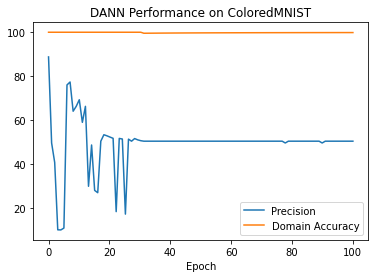

[[  0.50427383  88.76499939 100.        ]
 [  0.67879945  49.59000015 100.        ]
 [  1.28041744  40.72000122 100.        ]
 [  0.76799119  10.06499958 100.        ]
 [  2.91323376  10.02000046 100.        ]
 [  1.2436806   10.85999966 100.        ]
 [  0.68026936  76.01499939 100.        ]
 [  0.68312234  77.34500122 100.        ]
 [  0.68239307  64.05000305 100.        ]
 [  0.6870575   66.26999664 100.        ]
 [  0.69157881  69.27500153 100.        ]
 [  0.70319784  58.98500061 100.        ]
 [  0.70022893  66.26999664 100.        ]
 [  0.70622987  29.87999916 100.        ]
 [  0.69322515  48.68000031 100.        ]
 [  0.71667928  28.01000023 100.        ]
 [  0.72317845  26.95999908 100.        ]
 [  0.82333899  50.40999985 100.        ]
 [  0.78836018  53.34500122 100.        ]
 [  0.80584234  52.85499954 100.        ]
 [  0.82912219  52.27500153 100.        ]
 [  0.85397238  51.70999908 100.        ]
 [  0.83794707  18.34000015 100.        ]
 [  0.88827568  51.66999817 100.  

In [24]:
steps = np.linspace(0, 100, 100)
states = np.array(states)

plt.figure()
# plt.plot(steps, states[:, 0], c='blue', label='Loss')
plt.plot(steps, states[:, 1], label='Precision')
plt.plot(steps, states[:,2], label='Domain Accuracy')
plt.xlabel('Epoch')
plt.title('DANN Performance on ColoredMNIST')
plt.legend()
plt.show()
print(states)

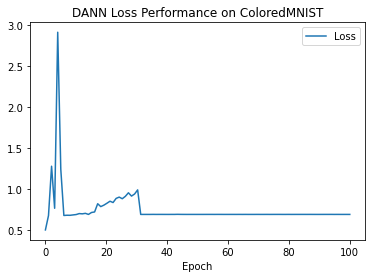

In [25]:
plt.figure()
plt.plot(steps, states[:, 0],  label='Loss')
plt.xlabel('Epoch')
plt.title('DANN Loss Performance on ColoredMNIST')
plt.legend()
plt.show()